#  **Import Libraries & Install Packages & Initialize Structures for Preprocessing:**

In [1]:
!pip install demoji
!pip install emoji
!pip install emot
!pip install googletrans==4.0.0-rc1
!pip install Unidecode
!pip install greek-stemmer-pos
!pip install spacy 
!pip install torch
!pip install optuna
!pip install torchmetrics
!pip install transformers
!python -m spacy download el_core_news_sm
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import logging
import csv
import torch
import os
import optuna
import spacy
import nltk
import re
import string
import emoji
import demoji
import emot
import itertools
import gensim
import multiprocessing
import numpy as np
import unicodedata as ud
import random
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import seaborn as sns
import optuna.visualization as vis
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence,pad_packed_sequence
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader,Dataset
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from googletrans import Translator
from emot.emo_unicode import EMOTICONS_EMO
from sklearn.metrics import precision_score, recall_score
from flashtext import KeywordProcessor
from sklearn.linear_model import LogisticRegression
from greek_stemmer import stemmer
from spacy.lang.el.examples import sentences 
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from transformers import  AutoTokenizer, AutoModel

nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 1.4 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.6 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=91d66afd061666604d4b958014cc85aa47b97f7aa7a9d5fa57b7b2d912be09ee
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61

True

In [2]:
#Read the datasets
train_df = pd.read_csv("/kaggle/input/training/train_set.csv")
val_df = pd.read_csv("/kaggle/input/validation/valid_set.csv")

#Concatenate train_df and val_df since they are the only ones that have a label and later split into train,validation and test set
df = pd.concat([train_df, val_df], ignore_index=True)
#Remove rows that don't have acceptable values 
acceptable_labels = ['POSITIVE','NEGATIVE','NEUTRAL']
df = df[df['Sentiment'].isin(acceptable_labels)].reset_index(drop=True)

#  Data Preprocessing 

In [3]:
#Creating a simple function to roughly convert most greeklish to greek
greek_alphabet = 'ΑαΒβΓγΔδΕεΖζΗηΘθΙιΚκΛλΜμΝνΞξΟοΠπΡρΣσςΤτΥυΦφΧχΨψΩω'
latin_alphabet = 'AaBbGgDdEeZzHhJjIiKkLlMmNnXxOoPpRrSssTtUuFfQqYyWw'
greeklish_to_greek = str.maketrans(latin_alphabet,greek_alphabet)

#Creating a Keyword Processor for converting emojis and emoticons to their greek meaning
translator = Translator()
emoticons = {**EMOTICONS_EMO}
kp_emojis = KeywordProcessor()
#We will create a dictionary that maps each emoticon in each equivalent greek word. We will repeat the same for emojis
for emoticon,value in emoticons.items() :
    try :
       greek_value = translator.translate(value.replace(":","").replace("_"," ").strip(), src='en', dest='el').text
    except :
        greek_value = ""
        
    kp_emojis.add_keyword(emoticon, greek_value)
    
# Load the Greek language model for spacy
nlp = spacy.load('el_core_news_sm')

#More Greek stopwords from our custom made file
with open('/kaggle/input/stopwords/Greek-Stopwords.txt', 'r') as file:
    # Read lines and remove '\n' from each line
    more_stopwords = [line.strip() for line in file.readlines()]
    
stops = set(stopwords.words('greek')).union(more_stopwords)

In [4]:
class DataPreprocessing(BaseEstimator, TransformerMixin):
    
    def remove_tags(self, text):
        return re.sub('@.*? ', '',text)
    
    def remove_urls(self, text):
        return re.sub(r'http.?://[^\s]+[\s]?', '',text)
    
    def emoji_to_word(self, text):
        #Get the map of emojis and their meaning in current text
        emojis = demoji.findall(text)
        #Convert the meaning to greek and add pair to keyword processor if it doesn't already exists
        for emoji,value in emojis.items():
            try :
               greek_value = translator.translate(value.replace(":","").replace("_"," ").strip(), src='en', dest='el').text
            except :
                greek_value = ""  
                
            # We replace emojis and emoticons with their corresponding greek words
            kp_emojis.add_keyword(emoji, greek_value) 
            
        return kp_emojis.replace_keywords(text)
    
    def remove_emoji(self, text):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    
    def remove_hashtags(self,text):
        #We remove the string following the hashtag
        words = text.split()
        return ' '.join(word for word in words if not word.startswith('#'))
    
    def remove_punctuation(self, text):
        # We leave a space in the place of every punctuation symbol to avoid mistaken concatenation between words
        greek_punc = punctuation + '«' +'»'+'’'
        trantab = str.maketrans(greek_punc, len(greek_punc)*' ')  
        return text.translate(trantab)
    
    def remove_accents(self, text):
        d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
        return ud.normalize('NFD',text).translate(d)
    
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)    
    
    def remove_stopwords(self, text):
        words = text.split() 
        #We remove strings that aren't words as well as stop words
        filtered_words = [word for word in words if (word not in stops) and len(word) > 1] 
        return " ".join(filtered_words) 
    
    def to_lower(self, text):
        return text.lower()
    
    def convert_greeklish(self, text):
        return text.translate(greeklish_to_greek)
    
    def remove_greeklish(self,text):
        # We replace every non-greek word with an empty string
        latin_pattern = r'\b[a-zA-Z]+\b'
        return re.sub(latin_pattern, '', text)
        
    def stemming(self,text):
        words = text.split() 
        stemmed_words = [stemmer.stem_word(word,'VB') for word in words]
        return " ".join(stemmed_words)
    
    def lemmatization(self,text):
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc])
    
    def remove_redundant(self,text):
        words = text.split()  
        cleaned_words = []

        for word in words:
            cleaned_word = word.rstrip('ς')  # Remove redundant ς characters from the end of the word
            cleaned_words.append(cleaned_word)

        return  ' '.join(cleaned_words) 
    
    def fit(self, X, y=None, **fit_params):
        return self   
    
    def transform(self, X, **transform_params):
        
        filtered_X = X.apply(self.remove_tags).apply(self.remove_urls)
        
        if 'remove_emojis' in transform_params:
            filtered_X = filtered_X.apply(self.remove_emoji)
        else :
            filtered_X = filtered_X.apply(self.emoji_to_word)
            
        if 'remove_hashtags' in transform_params:
            filtered_X = filtered_X.apply(self.remove_hashtags)            
            
        filtered_X = filtered_X.apply(self.remove_punctuation).apply(self.remove_greeklish)
        
        if 'remove_digits' in transform_params:
            filtered_X = filtered_X.apply(self.remove_digits)
            
        if 'remove_greeklish' in transform_params:
            filtered_X = filtered_X.apply(self.remove_greeklish)   
        else :
            filtered_X = filtered_X.apply(self.convert_greeklish)   
            
        if 'lemmatization'in transform_params:
            filtered_X = filtered_X.apply(self.lemmatization)
            
        elif 'stemming'in transform_params:
            filtered_X = filtered_X.apply(self.stemming)
        
        filtered_X = filtered_X.apply(self.remove_accents).apply(self.to_lower).apply(self.remove_redundant).apply(self.remove_stopwords)
        return filtered_X  
    
    def fit_transform(self, X, **transform_params):
        # Fit phase
        self.fit(X)

        # Transform phase using the provided transform_params
        return self.transform(X, **transform_params)  

# **Data Preprocessing & Stats:**

Running in  cpu


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'τσιπρα'),
  Text(1, 0, 'μητσοτακη'),
  Text(2, 0, 'νδ'),
  Text(3, 0, 'συριζα'),
  Text(4, 0, 'κκε'),
  Text(5, 0, 'εκλογες2019'),
  Text(6, 0, '2019'),
  Text(7, 0, 'κανω'),
  Text(8, 0, 'σκαι'),
  Text(9, 0, 'πασοκ'),
  Text(10, 0, 'νεο'),
  Text(11, 0, 'κιναλ'),
  Text(12, 0, 'εκλογη'),
  Text(13, 0, 'εκλογε'),
  Text(14, 0, 'μπορω'),
  Text(15, 0, 'αλεξη'),
  Text(16, 0, 'ελλαδα'),
  Text(17, 0, 'συνεντευξη'),
  Text(18, 0, 'λεγω'),
  Text(19, 0, 'θελω')])

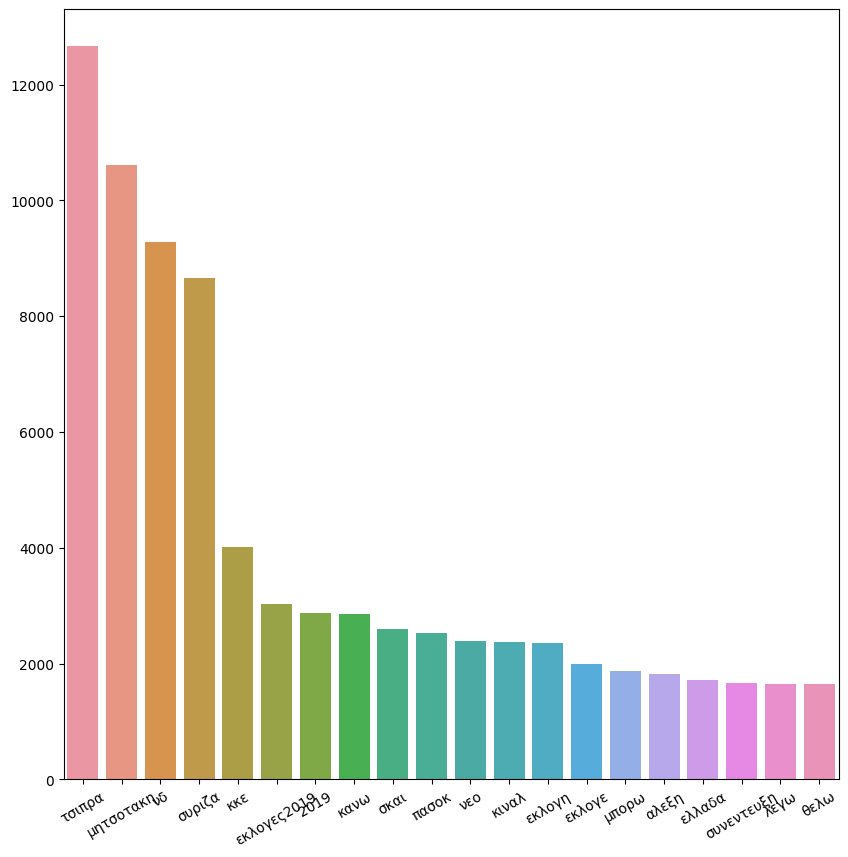

In [5]:
#Data Cleaning
Processor = DataPreprocessing()
params = {'remove_emojis' : 'y','lemmatization': 'y'}
df['Text'] = Processor.fit_transform(df['Text'],**params)

# Filter out rows with non-zero token count in the 'Text' column
empty_text = df[df['Text'].apply(lambda x: len(x.split()) == 0)].index

#Reset the index to make it consistent after removing rows
df.drop(empty_text, inplace=True)
df.reset_index(drop=True, inplace=True)

labels = df['Sentiment']
final_df = df.drop('Sentiment', axis=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running in ",device)

labels_to_int = {"POSITIVE" : 0, "NEGATIVE" : 1 , "NEUTRAL" : 2}
int_to_labels = {0 : "POSITIVE", 1 : "NEGATIVE", 2 : "NEUTRAL"}
labels = labels.apply(lambda x: labels_to_int.get(x))
labels_tensor = torch.tensor(labels, device=device)

#Read Actual Test Set 
test_df = pd.read_csv("/kaggle/input/testset/test_set.csv")

#Perform best Data Preprocessing Technique 
params = {'remove_emojis' : 'y','lemmatization': 'y'}
test_df['Text'] = Processor.fit_transform(test_df['Text'],**params)

# Filter out rows with non-zero token count in the 'Text' column
empty_text = test_df[test_df['Text'].apply(lambda x: len(x.split()) == 0)].index

# Reset the index to make it consistent after removing rows
test_df.drop(empty_text, inplace=True)

#Analysing words' frequency and statistics
words = nltk.tokenize.word_tokenize(df['Text'].str.cat(sep=' '))
word_dist = nltk.FreqDist(words)
most_common = pd.Series(dict(word_dist.most_common(20)))
fig, ax = plt.subplots(figsize=(10,10))
all_plot = sns.barplot(x=most_common.index, y=most_common.values, ax=ax)
plt.xticks(rotation=30)

# **Creating Datasets**

In [6]:
class TweetDataset(Dataset):
    def __init__(self, texts ,tokenizer , labels=None):
        
        self.input_ids = [tokenizer.encode(text) for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx): 
        
        indices = torch.tensor(self.input_ids[idx])
        labels = torch.tensor(self.labels[idx])
        att_masks = [int(token_id > 0) for token_id in indices]
        
        if self.labels is not None:
            return (indices,att_masks,labels)
        
        return indices,att_masks

In [7]:
def set_seed(seed = 45):

    #For consistency in results we use a deterministic way to control the source of random number generator
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

In [8]:
set_seed()

In [9]:
def custom_collate(batch) :
    
    inputs = [torch.tensor(item[0]) for item in batch]  # Extract input sequences
    # Perform padding on input sequences
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    att_masks = [[int(token_id > 0) for token_id in input] for input in padded_inputs]
    targets = [item[2] for item in batch]  # Extract targets

    return (padded_inputs,torch.tensor(att_masks),torch.tensor(targets))   

In [10]:
def create_loaders(tokenizer,X,Y,custom_collate,batch,test_loader=True) :
            
    if test_loader:
        
        #Splitting into Training (70), Validation & Test Set (15 each)
        
        train_X, remaining_X ,train_Y, remaining_Y = train_test_split(X, Y, test_size=0.3, random_state=28)
        val_X, test_X , val_Y, test_Y = train_test_split(remaining_X, remaining_Y, test_size=0.5, random_state=28)
        
        train_set = TweetDataset(train_X.values.flatten(), tokenizer, train_Y)
        train_loader = DataLoader(train_set, batch_size = batch ,shuffle=False, collate_fn=custom_collate)

        val_set = TweetDataset(val_X.values.flatten() ,tokenizer ,val_Y)
        val_loader = DataLoader(val_set, batch_size = batch,shuffle=False, collate_fn=custom_collate)

        test_set = TweetDataset(test_X.values.flatten() ,tokenizer, test_Y)
        test_loader = DataLoader(test_set, batch_size = batch ,shuffle=False, collate_fn=custom_collate)
        
        return (train_loader,val_loader,test_loader)
    
    #Splitting into Training (80) & Validation (20) if no test loader was asked

    train_X, val_X ,train_Y, val_Y = train_test_split(final_df['Text'], labels, test_size=0.2, random_state=28)

    train_set = TweetDataset(train_X.values.flatten(),tokenizer, train_Y.values.flatten())
    train_loader = DataLoader(train_set, batch_size = batch ,shuffle=False, collate_fn=custom_collate)

    val_set = TweetDataset(val_X.values.flatten(),tokenizer, val_Y.values.flatten())
    val_loader = DataLoader(val_set, batch_size = batch ,shuffle=False, collate_fn=custom_collate)

    return (train_loader,val_loader)

In [11]:
class GRBert(nn.Module):
  def __init__(self, dropout, hidden, activation,pretrained_path,output_dim):
    super(GRBert, self).__init__()
    
    self.pretrained = AutoModel.from_pretrained(pretrained_path)
    self.dropout = nn.Dropout(dropout) 
    self.linear = nn.Sequential(
          nn.Linear(768, hidden, device=device),   #Model follows English Bert Model having 768 hidden layers 
          activation(),
		  nn.Dropout(dropout),
          nn.Linear(hidden,output_dim, device=device),
        )
    # Freeze pretrained layer to speed up computations
    for param in self.pretrained.parameters():
        param.requires_grad = False
        
  def forward(self, ids, mask):
    output = self.pretrained(ids, mask)
    return self.dropout(self.linear(output[0][:, 0, :]))
   

  def predict(loader, neural):
    neural.eval()
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            X = batch[0].to(device)
            att_mask = batch[1].to(device)
            pred = neural(X,att_mask)
            # Accumulate predictions and labels for computing metrics after all batches
            all_preds.extend(pred.argmax(1).cpu().tolist())

    return all_preds

# **Testing**

In [12]:
def evaluation(loader, loss_func, neural):
    neural.eval()
    total_error = 0
    total_correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            # `batch` contains three PyTorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            X = batch[0].to(device)
            att_mask = batch[1].to(device)
            label = batch[2].to(device)
            pred = neural(X, att_mask)
            total_correct += (pred.argmax(1) == label.squeeze()).sum().item()
            total_error += loss_func(pred, label).item()

            # Accumulate predictions and labels for computing metrics after all batches
            all_preds.extend(pred.argmax(1).cpu().tolist())
            all_labels.extend(label.cpu().tolist())

    avg_error = total_error / len(loader.dataset)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    accuracy = total_correct / len(loader.dataset) * 100
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_error, f1_macro, accuracy, conf_matrix, all_preds

# **Training**

In [13]:
#We do validation in every single epoch so it has to be combined in the training function to evaluate the efficiency of current parameters
def train_and_val(epochs,optimizer,train_loader,val_loader,loss_func,neural,patience) :

  best_score = -1
  continuous = 0
  train_scores = []
  train_loss = []
  val_scores = []
  val_loss = []   
    
  #Iterate through batches for every epoch
  for epoch in range(epochs) :
    neural.train()   
    #iterating through batches
    for batch in train_loader :
      # set to zero the parameter gradients
      optimizer.zero_grad()
      # `batch` contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: labels 
      X = batch[0].to(device)
      att_mask = batch[1].to(device)
      label = batch[2].to(device)
      pred = neural(X,att_mask)
      error = loss_func(pred,label.squeeze())
      # computing gradients/the direction that fits our objective
      error.backward()  
      #optimizing weights/slightly adjusting parameters
      optimizer.step()
    #compute validation scores for each epoch
    loss , f1 , acc , cf_matr  , preds = evaluation(val_loader,loss_func,neural)
    val_scores += [acc]
    val_loss += [loss]
    loss , f1 , acc , cf_matr , preds = evaluation(train_loader,loss_func,neural)
    train_scores += [acc]  
    train_loss += [loss]
    if acc > best_score :
      wanted = neural
      best_score = acc
      best_epoch = epoch
    else :
      continuous += 1
      if continuous == patience :
          return wanted,best_epoch,train_scores,train_loss,val_scores,val_loss
        
  return wanted,best_epoch,train_scores,train_loss,val_scores,val_loss

In [24]:
#Prints best parameters of study and relevant statistics 
def showcase(study,path,output_dim,acceptable_labels):
    
    # Print the best hyperparameters and their corresponding accuracy
    best_parameters = study.best_params

    print("Best parameters ",best_parameters)
    train_loader,val_loader,test_loader = create_loaders(tokenizer,final_df['Text'], labels_tensor,custom_collate,best_parameters['batch_size'])

    gr_bert = GRBert(best_parameters['drop'],best_parameters['hidden'],best_parameters['activation_function'],path,output_dim).to(device)

    optimizer = getattr(torch.optim, best_parameters['optimizer'])(gr_bert.parameters(), lr=best_parameters['lr'])
    loss_func = nn.CrossEntropyLoss()
    epochs = best_parameters['epochs']
    patience = best_parameters['patience']
    output = train_and_val(epochs,optimizer,train_loader,val_loader,loss_func,gr_bert,patience)

    #Performance of best Model
    print("Best epoch is : ",output[1])
    loss , f1 , best_accuracy , cf_matr , preds = evaluation(test_loader,loss_func,output[0])
    print("F1-score for best model is : ",f1*100 ,", best  accuracy is ", best_accuracy)
    
    plt.figure()

    #Print hyperparameter's importance
    vis.plot_param_importances(study)
    
    plt.show()

    #Plotting the confusion matrix
    cm_df = pd.DataFrame(cf_matr,index = acceptable_labels, columns = acceptable_labels)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [15]:
def plot_learning_curve(best_parameters,path,output_dim,train_loader,val_loader) :
    
    gr_bert = GRBert(best_parameters['drop'],best_parameters['hidden'],best_parameters['activation_function'],path,output_dim).to(device)

    plt.figure()

    #Train for all epochs
    epochs = best_parameters['epochs']
    patience = epochs
    optimizer = getattr(torch.optim, best_parameters['optimizer'])(gr_bert.parameters(), lr=best_parameters['lr'])
    loss_func = nn.CrossEntropyLoss()
    best_model,best_epoch,train_scores,train_loss,val_scores,val_loss = train_and_val(epochs,optimizer,train_loader,val_loader,loss_func,gr_bert,patience)

    epoch_list = range(1, epochs + 1)
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.plot(epoch_list, train_scores, label="Train Score")
    plt.plot(epoch_list, val_scores, label="Validation Score")
    plt.legend()  
    plt.show()    
    
    plt.figure()
    
    plt.grid()
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.plot(epoch_list, train_loss, label="Training Loss")
    plt.plot(epoch_list, val_loss, label="Validation Loss")
    plt.legend()  
    plt.show()    

In [16]:
def create_output_file(X,tokenizer,custom_collate,path,best_parameters,output_dim,train_loader,val_loader,output_name) :

    #Create Dataset & Dataloader for test_df
    test_set = TweetDataset(X.values.flatten(), tokenizer)
    test_loader = DataLoader(test_set, batch_size = best_parameters['batch_size'] ,shuffle=False, collate_fn=custom_collate)

    #Train the model with the entire dataset this time
    gr_bert = GRBert(best_parameters['drop'],best_parameters['hidden'],best_parameters['activation_function'],path,output_dim).to(device)

    optimizer = getattr(torch.optim, best_parameters['optimizer'])(gr_bert.parameters(), lr=best_parameters['lr'])
    loss_func = nn.CrossEntropyLoss()
    epochs = best_parameters['epochs']
    patience = best_parameters['patience']
    output = train_and_val(epochs,optimizer,train_loader,val_loader,loss_func,gr_bert,patience)

    #Predict using best model
    test_pred = output[0].predict(test_loader)

    # Create submission.csv output file
    with open(output_name, "w", newline='') as output_file:
        # Create a CSV writer
        submission = csv.writer(output_file)

        # Write the header row
        submission.writerow(["Id", "Predicted"])

        # Write the data rows
        for idx, predicted_value in zip(X['New_ID'], test_pred):
            submission.writerow([idx, int_to_labels[predicted_value]])    

# **Experimenting on GreekBERT Model**

> #   Hyperparameter Tuning

In [17]:
path = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = AutoTokenizer.from_pretrained(path)
output_dim = 3

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [19]:
# Set the logging level to CRITICAL to deactivate messages
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

def objective(trial):
    
    # Define the search space for model's hyperparameters
    epoch = trial.suggest_categorical('epochs', [5,10, 15])                                                                        
    drop = trial.suggest_float('drop', 0.5, 0.8, step=0.1)    
    batch_size = trial.suggest_categorical('batch_size', [4,8,16,32]) 
    hidden = trial.suggest_int('hidden',50,256,step=2)
    rate = trial.suggest_float('lr', 1e-6,1e-2,step=1e-3)
    patience = trial.suggest_categorical('patience', [5, 10,15])
    opt = trial.suggest_categorical('optimizer', ["SGD", "Adam", "Adagrad", "Adadelta", "Adamax"])
    func = trial.suggest_categorical('activation_function', [nn.ReLU, nn.Tanh, nn.LeakyReLU, nn.CELU, nn.Hardshrink])
    
    torch.cuda.empty_cache()
    
    train_loader,val_loader,test_loader = create_loaders(tokenizer,final_df['Text'], labels_tensor,custom_collate,batch_size)
    
    gr_bert = GRBert(drop,hidden,func,path,output_dim).to(device)
    optimizer = getattr(torch.optim, opt)(gr_bert.parameters(), lr=rate)
    loss_func = nn.CrossEntropyLoss()
    output = train_and_val(epoch, optimizer, train_loader, val_loader,loss_func,gr_bert,patience)
    
    #Compute the test accuracy of the best model (best validation accuracy out of all epochs) on the test set
    loss, f1, acc, cf_matr , preds = evaluation(test_loader, loss_func,output[0])
    
    del gr_bert
    
    return acc  # The accuracy is the metric to be maximized

In [ ]:
study = optuna.create_study(direction='maximize')  # maximize accuracy
study.optimize(objective, n_trials=20)
showcase(study,path,output_dim,acceptable_labels)

#Best parameters optuna found
best_parameters = {
    'epochs': 2,
    'drop': 0.6,
    'batch_size': 8,
    'hidden': 100,
    'lr': 0.0001,
    'patience': 5,
    'optimizer': "Adadelta",
    'activation_function': nn.ReLU
}


Best parameters  {'epochs': 2, 'drop': 0.6, 'batch_size': 8, 'hidden': 100, 'lr': 0.0001, 'patience': 5, 'optimizer': 'Adadelta', 'activation_function': <class 'torch.nn.modules.activation.ReLU'>}


> #   Metrics & Plots for Best Model:

In [ ]:
torch.cuda.empty_cache()

#Plotting Learning Curve

#Splitting into training & Validation Set Only this time to get a clearer picture of the performances
train_loader,val_loader = create_loaders(tokenizer,final_df['Text'],labels_tensor,custom_collate,best_parameters['batch_size'],False)

plot_learning_curve(best_parameters,path,output_dim,train_loader,val_loader)

> #    Predictions

In [ ]:
torch.cuda.empty_cache()

create_output_file(test_df['Text'],tokenizer,custom_collate,path,best_parameters,output_dim,train_loader,val_loader,"submission.csv")

# **Experimenting on DistilGREEK-BERT Model**

> #   Hyperparmeter Tuning

In [ ]:
path_distil = "EftychiaKarav/DistilGREEK-BERT"
tokenizer_distil = AutoTokenizer.from_pretrained(path_distil)

In [ ]:
# Set the logging level to CRITICAL to deactivate messages
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

def objective(trial):
    
    # Define the search space for model's hyperparameters
    epoch = trial.suggest_categorical('epochs', [5,10, 15)                                                                        
    drop = trial.suggest_float('drop', 0.5, 0.8, step=0.1) 
    batch_size = trial.suggest_categorical('batch_size', [4,8,16,32]) 
    hidden = trial.suggest_int('hidden',50,256,step=2)
    rate = trial.suggest_float('lr', 1e-6,1e-2,step=1e-3)
    patience = trial.suggest_categorical('patience', [5, 10,15])
    opt = trial.suggest_categorical('optimizer', ["SGD", "Adam", "Adagrad", "Adadelta", "Adamax"])
    func = trial.suggest_categorical('activation_function', [nn.ReLU, nn.Tanh, nn.LeakyReLU, nn.CELU, nn.Hardshrink])
    
    torch.cuda.empty_cache()
    
    train_loader,val_loader,test_loader = create_loaders(tokenizer_distil,final_df['Text'], labels_tensor,custom_collate,batch_size)
    
    gr_bert = GRBert(drop,hidden,func,path_distil,output_dim).to(device)
    optimizer = getattr(torch.optim, opt)(gr_bert.parameters(), lr=rate)
    loss_func = nn.CrossEntropyLoss()
    output = train_and_val(epoch, optimizer, train_loader, val_loader,loss_func,gr_bert,patience)
    
    #Compute the test accuracy of the best model (best validation accuracy out of all epochs) on the test set
    loss, f1, acc, cf_matr , preds = evaluation(test_loader, loss_func,output[0])
​
    del gr_bert

    return acc  # The accuracy is the metric to be maximized

In [ ]:
# study = optuna.create_study(direction='maximize')  # maximize accuracy
# study.optimize(objective, n_trials=20)# Run optimization for 30 trials
# showcase(study,path_distil,output_dim,acceptable_labels)

#Best parameters optuna found
best_parameters_distil = {
    'epochs': 15,
    'drop': 0.6,
    'batch_size': 8,  
    'hidden': 100,
    'lr': 0.0001,
    'patience': 5,
    'optimizer': "Adadelta",
    'activation_function': nn.ReLU
}

> #   Metrics & Plots for Best Model:

In [ ]:
#Plotting Learning Curve
torch.cuda.empty_cache()

#Splitting into training & Validation Set Only this time to get a clearer picture of the performances
train_loader,val_loader = create_loaders(tokenizer_distil,final_df['Text'],labels_tensor,custom_collate,best_parameters_distil['batch_size'],False)

plot_learning_curve(best_parameters_distil,path,output_dim,train_loader,val_loader)

> #    Predictions :

In [ ]:
torch.cuda.empty_cache()

#As the assignment requests we only produce predictions for GREEK-BERT 
create_output_file(test_df['Text'],tokenizer_distil,custom_collate,path_distil,best_parameters_distil,output_dim,train_loader,val_loader,"submission_distil.csv")